# CNN_B SETTINGS


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np     
import random           
from scipy.io import loadmat
from scipy import signal
import warnings
import string
import os

from keras.layers import *
from keras.models import Model
from tensorflow.keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler


import mne




contributor_selected = "II"                                 
contributor_train_file_path = '../data/Contributor_' + contributor_selected + '_Train.mat'
contributor_test_file_path = '../data/Contributor_' + contributor_selected + '_Test.mat'
channel_name_file_path = '../data/channels.csv'
warnings.filterwarnings('ignore')

# Channel selection
channels = [10, 33, 48, 50, 52, 55, 59, 61]            

# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signals from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 8)**;
6.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;









In [35]:
from scipy.io import loadmat
from scipy import signal
from bundle.DataCraft import * 

data_train = loadmat(contributor_train_file_path)


# Take only the 8 selected channels of the singal [Fz, Cz, Pz, P3, P4, Po7, Po8, Oz]
signals_train = data_train['Signal']
signals_train = signals_train[:, :, channels]
flashing_train = data_train['Flashing']
stimulus_train = data_train['StimulusType']
word_train = data_train['TargetChar']
sampling_frequency = 240
repetitions = 15
recording_duration_train = (len(signals_train)) * (len(signals_train[0])) / (sampling_frequency * 60)
trials_train = len(word_train[0])

print("Train Data:")
print_data(signals_train,word_train, contributor_selected, sampling_frequency)

Train Data:
Contributor     Sampling Freq. (Hz)  Recording (min)      Trials     Spelled Word                  
II              240.00               46.01                85         VGREAAH8TVRHBYN_UGCOLO4EUERDOO
                                                                     HCIFOMDNU6LQCPKEIREKOYRQIDJXPB
                                                                     KOJDWZEUEWWFOEBHXTQTTZUMO     


In [36]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(trials_train):
    signals_train[trial, :, :] = signal.filtfilt(b, a, signals_train[trial, :, :], axis=0)
    
    # Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_train[0])))

signals_train = signals_train[:, 0:-1:SCALE_FACTOR, :]
flashing_train = flashing_train[:, 0:-1:SCALE_FACTOR]
stimulus_train = stimulus_train[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_train[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [37]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals_train[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(trials_train):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing_train[trial, sample - 1] == 0 and flashing_train[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_train[trial, lower_sample:upper_sample, :]                
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus_train[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 78, 8)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

Features tensor shape: (15300, 78, 8)


# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 8)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [38]:
data_test = loadmat(contributor_test_file_path)

# Get the variables of interest from the loaded dictionary
signals_test = data_test['Signal']
signals_test = signals_test[:, :, channels]
flashing_test = data_test['Flashing']
word_test =  data_test['TargetChar']
stimulus_code_test = data_test['StimulusCode']

sampling_frequency = 240
repetitions = 15
recording_duration_test = (len(signals_test)) * (len(signals_test[0])) / (sampling_frequency * 60)
trials_test = len(word_test[0])
samples_per_trial_test = len(signals_test[0])

print("Test Data:")
print_data(signals_test,word_test, contributor_selected, sampling_frequency)

Test Data:
Contributor     Sampling Freq. (Hz)  Recording (min)      Trials     Spelled Word                  
II              240.00               54.12                100        MERMIROOMUHJPXJOHUVLEORZP3GLOO
                                                                     7AUFDKEFTWEOOALZOP9ROCGZET1Y19
                                                                     EWX65QUYU7NAK_4YCJDVDNGQXODBEV
                                                                     2B5EFDIDNR                    


In [39]:
# Create characters matrix
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(samples_per_trial_test)] for i in range(trials_test)]
stimulus_test = np.array(stimulus_test)

for trial in range(trials_test):
    counter=0
    for sample in range(samples_per_trial_test):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [40]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(trials_test):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)
    
# Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [41]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
samples_per_trial_test = len(signals_train[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(trials_test):
    for sample in (range(samples_per_trial_test)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes 
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 78, 64)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

Features tensor shape: (18000, 78, 8)


# CNN_B model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted datasets;
5.   CNN2a performance assessment;

In [42]:
# Randomizing function for bias and weights of the network
def cecotti_normal(shape, dtype = None, partition_info = None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    return K.random_normal(shape, mean = 0.0, stddev = (1.0 / fan_in))

# Custom tanh activation function
def scaled_tanh(z):
    return 1.7159 * K.tanh((2.0 / 3.0) * z)

# Build the model
def CNN_B_model(channels=8, filters=10):
    model = Sequential([
        Conv1D(
            filters = filters,
            kernel_size = 1,
            padding = "same",
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
            input_shape = (78, channels)
        ),
        Conv1D(
            filters = 50,
            kernel_size = 13,
            padding = "valid",
            strides = 11,
            bias_initializer = cecotti_normal,
            kernel_initializer = cecotti_normal,
            use_bias = True,
            activation = scaled_tanh,
        ),
        Flatten(),
        Dense(100, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

# Training parameters
BATCH_SIZE = 256
EPOCHS = 200
VALID_SPLIT = 0.2
SHUFFLE = 1 # set to 1 to shuffle subsets during training

# Model summary
# Model definition
model = CNN_B_model(channels=8, filters=10)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 78, 10)         │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 6, 50)          │         6,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,841 (143.91 KB)

 Trainable params: 36,841 (143.91 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min', 
                              patience = 50, 
                              restore_best_weights = True)

# Callback to keep track of model statistics
history = model.fit(x=train_features, 
                    y=train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=VALID_SPLIT, 
                    callbacks=[earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})

# Find the epoch with the lowest validation loss
best_epoch = np.argmin(history.history['val_loss'])
print(f"Best epoch: {best_epoch + 1} with validation loss: {history.history['val_loss'][best_epoch]}")

# Reload the best weights manually
best_weights = model.get_weights()
model.set_weights(best_weights)

# Define a new model to reuse the best configuration
best_model = CNN_B_model(channels=8, filters=10)
best_model.set_weights(best_weights)

# Compile the best model
best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4816 - loss: 0.3924 - val_accuracy: 0.7376 - val_loss: 0.1794
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7208 - loss: 0.3139 - val_accuracy: 0.7029 - val_loss: 0.1974
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7276 - loss: 0.3123 - val_accuracy: 0.7644 - val_loss: 0.1627
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7357 - loss: 0.3054 - val_accuracy: 0.7810 - val_loss: 0.1527
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7486 - loss: 0.2954 - val_accuracy: 0.7500 - val_loss: 0.1710
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7426 - loss: 0.2981 - val_accuracy: 0.7526 - val_loss: 0.1685
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7350 - loss: 0.2999 - val_accuracy: 0.7536 - val_loss: 0.1707
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7537 - loss: 0.2904 - val_accuracy: 0.7176 - 

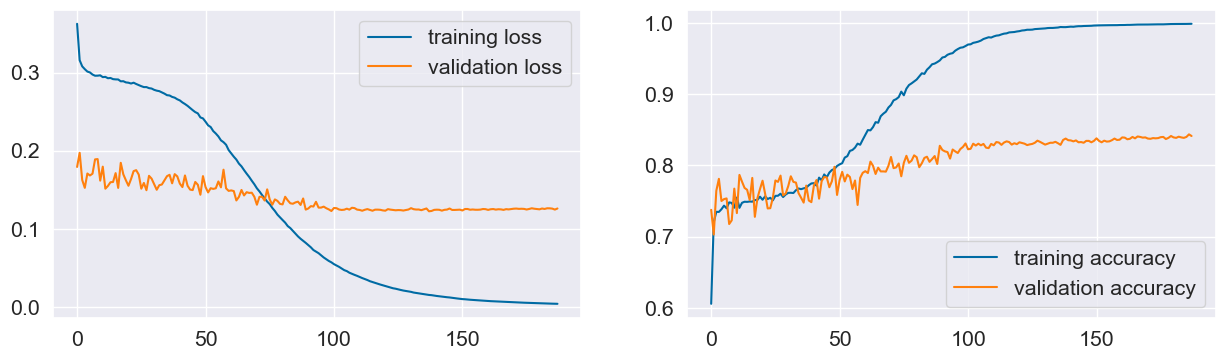

In [44]:
plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

plt.show()

['Cz', 'Fz', 'P3', 'Pz', 'P4', 'Po7', 'Po8', 'Oz']
['Cz', 'Fz', 'P3', 'Pz', 'P4', 'Oz']
[5, 6]


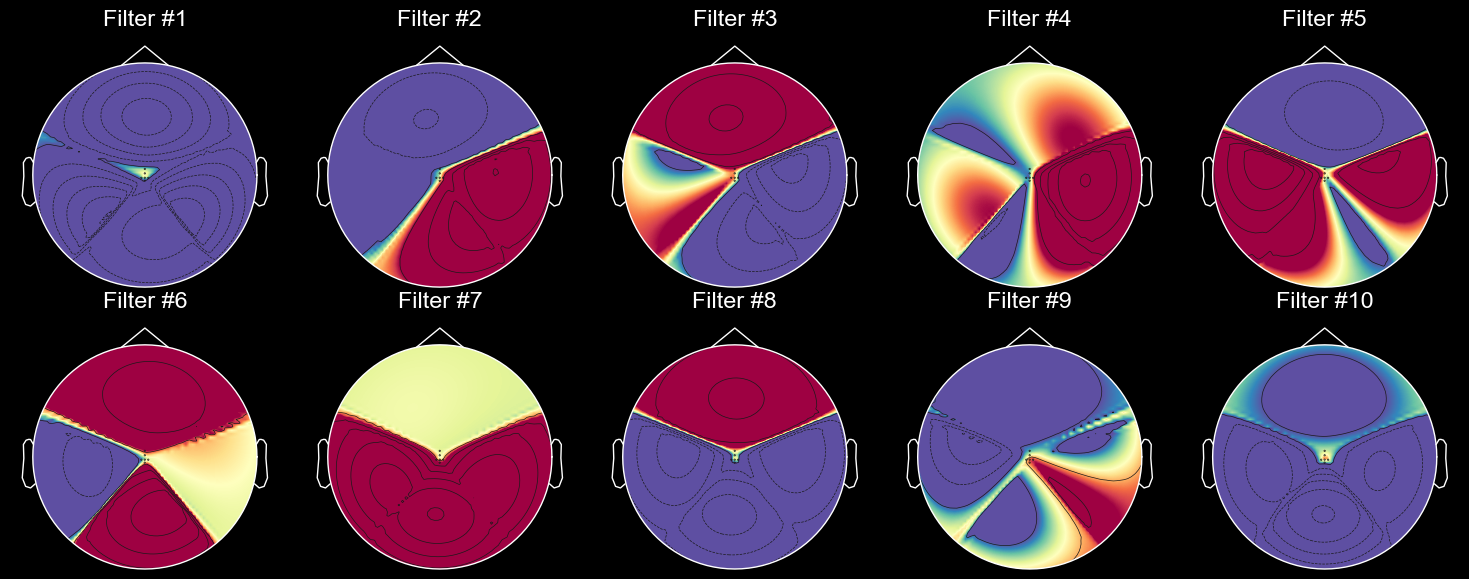

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import csv

# Read CSV file into a Python list
all_electrode_names = []

with open(channel_name_file_path, "r") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        all_electrode_names.extend(row)  # Add each row to the list (handles single-column CSV)


# Create array has the electrode_names has this index channels = [10, 33, 48, 50, 52, 55, 59, 61]  
electrode_names = [all_electrode_names[i] for i in channels]
print(electrode_names)

# Remove the electrodes 'Po8' from the electrode_names list
electrode_names.remove('Po7')
electrode_names.remove('Po8')
print(electrode_names)

# Create array has the original index for electrode we need to remove from the weights
index = [5,6]
print(index)
    
montage = mne.channels.make_standard_montage("standard_1020")

# Create random weights for 10 filters (20 channels)
n_channels = len(electrode_names)
n_filters = 10

# Create a list of weights for all filters
nf = []
for filt in range(10):
    nf.append(abs(np.array(best_model.get_weights()[0])[0, :, filt]))
# remove the channels from the weights 
nf = np.delete(nf, index, axis=1)

# Create an Info object with EEG channel names
info = mne.create_info(ch_names=electrode_names, sfreq=1000, ch_types="eeg")
info.set_montage(montage)

# Plot topomap for each filter
# Set give me array of background color
fig, axes = plt.subplots(2, 5, figsize=(15, 6), facecolor="#000000")  # Set overall background to black
axes = axes.flatten()

for i in range(n_filters):
    ax = axes[i]
    mne.viz.plot_topomap(
        nf[i], info, axes=ax, cmap="Spectral_r", sphere=1.2, show=False  # Adjust `sphere` to scale brain size
    )
    ax.set_title(f"Filter #{i + 1}", color="white")  # Set title color to white for better visibility

plt.tight_layout()
plt.show()


In [46]:
# Accuracy over the testing set
predictions = best_model.predict(test_features)
predictions = np.round(predictions)

score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
print("\nPredictions: {}\nSolutions:   {}".format(list(map(int, predictions))[:50], list(map(int, test_labels))[:50]))

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model performance on test set:	[ Loss: 0.6243	Accuracy: 0.8127 ]

Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


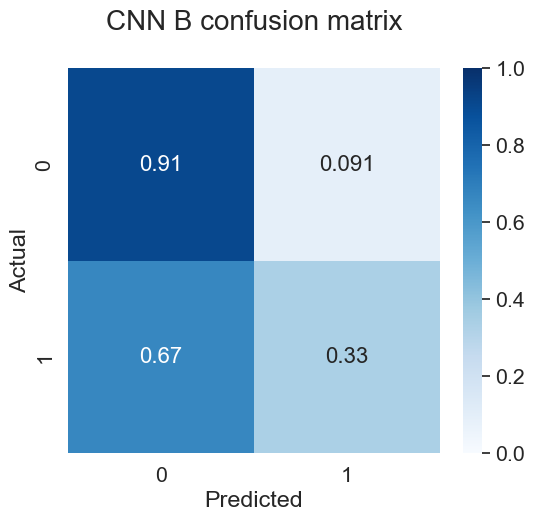

In [47]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data_train = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data_train / np.full(data_train.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("CNN B confusion matrix\n", fontsize=20)
plt.show()

In [48]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

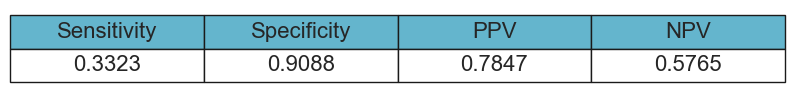

In [49]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())], 
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()